<a href="https://www.kaggle.com/yongwonjin/titanic-survival-classification?scriptVersionId=89491170" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Titanic Survival Classification
Based on the notebooks by:  
[Alexis Cook](http://www.kaggle.com/alexisbcook/titanic-tutorial)  
[Francisco Javier Gallego](https://www.kaggle.com/javigallego/top-5-hyperparameter-tuning-ensemble-modeling?scriptVersionId=88795500)  
[Woo Seung Han](https://www.kaggle.com/hadeux/titanic-survivor-predict-eda-lightgbm-kor-eng/notebook)  

In [1]:
# autocomplete ON
%config Completer.use_jedi = False

In [2]:
# Load libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt


<div style='color: white; display: fill; 
    border-radius: 8px; background-color: black;
    font-size: 150%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: white;'> 
        <b>1 &nbsp; Data prep & EDA</b>
    </p>
</div> 

### <b> 1.1 <span style='color:red'> | </span> Load data </b>

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [4]:
# Load train and test data
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')

# Concatenate two data sets
df_data = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)
dfs = [df_train, df_test]

### <b> 1.2 <span style='color:red'> | </span> EDA </b>

In [5]:
## Visually inspect first few rows of each table
df_train.head(3)
# df_test.head(3)
# gender_submission.head(3)

### Task is to predict "Survived" for each "PassengerId"

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
## Show table schema
# df_train.info()
# df_test.info()
df_data.info()

### Excluding the Id and independent variable, there are 10 features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [7]:
# Check for any duplicates
df_data.duplicated().value_counts()

False    1309
dtype: int64

In [8]:
## Count missing values from each column
# df_train.isna().sum()
df_test.isna().sum()
# df_data.isna().sum()

### Columns "Age", "Cabin", and "Embarked" have missing values

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [9]:
# Functions for drawing pair plots with annotations
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    
def pairPlot(data, column=None):
    if column:
        num = len(data[column].unique())
        g = sns.PairGrid(data, hue=column, hue_kws=sns.color_palette('vlag', n_colors=2, as_cmap=True), dropna=True)
        g.map_offdiag(sns.scatterplot)
        g.add_legend()
    else:
        g = sns.PairGrid(data, dropna=True)
        g.map_offdiag(corrfunc)
        g.map_offdiag(sns.regplot)
    g.map_diag(sns.histplot)
    return g

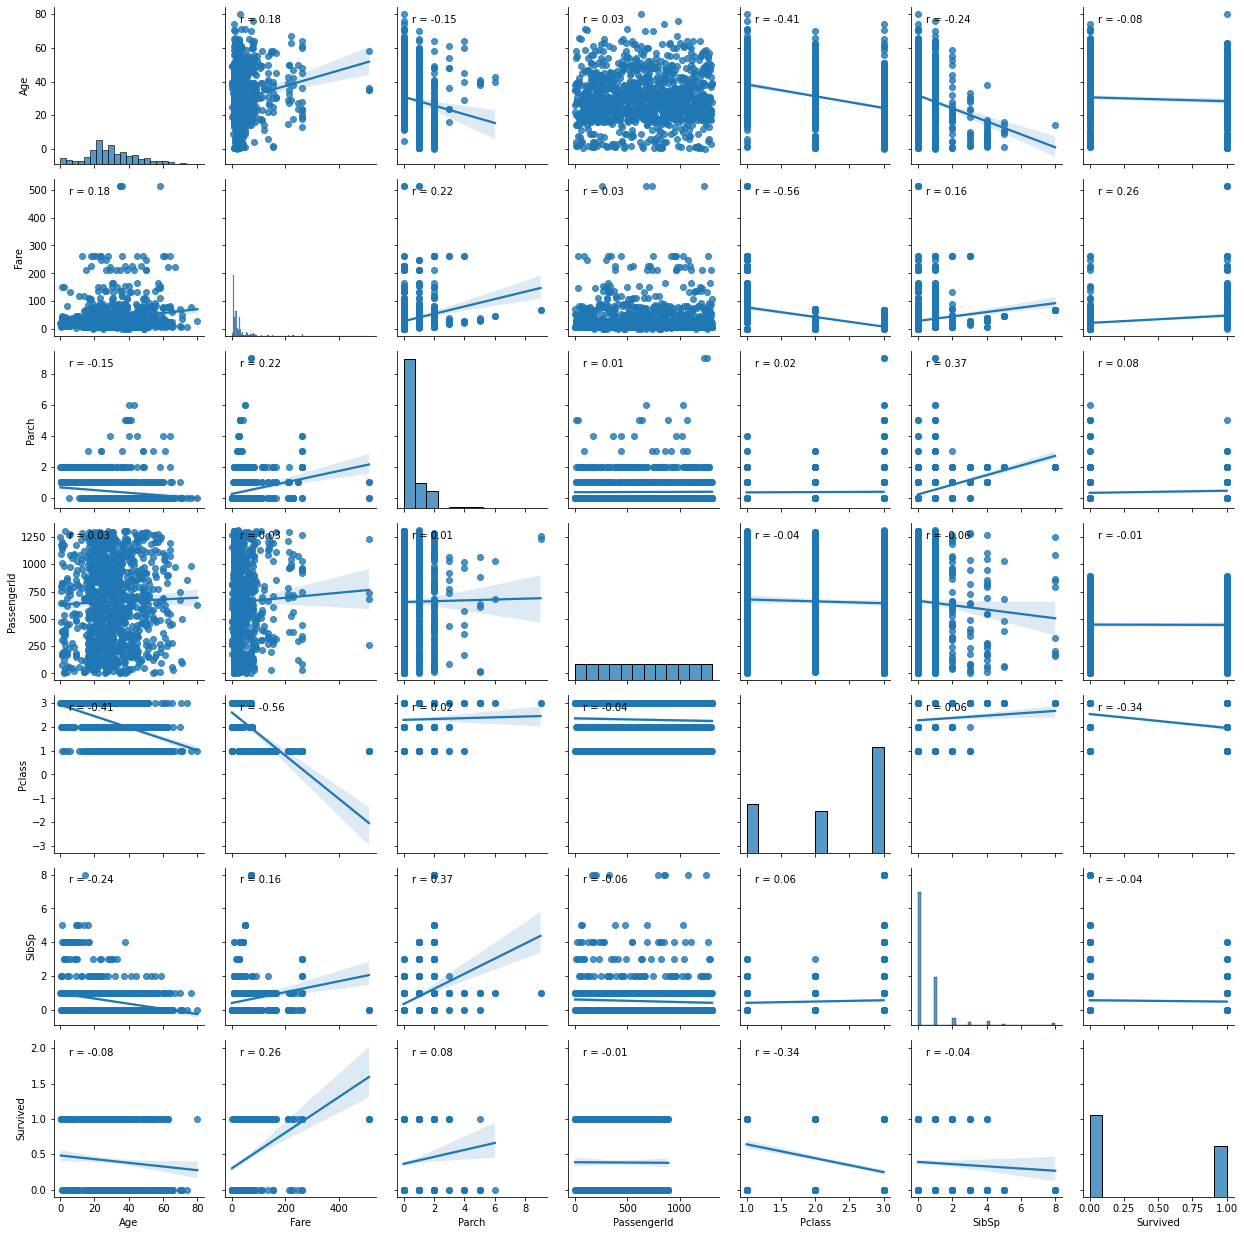

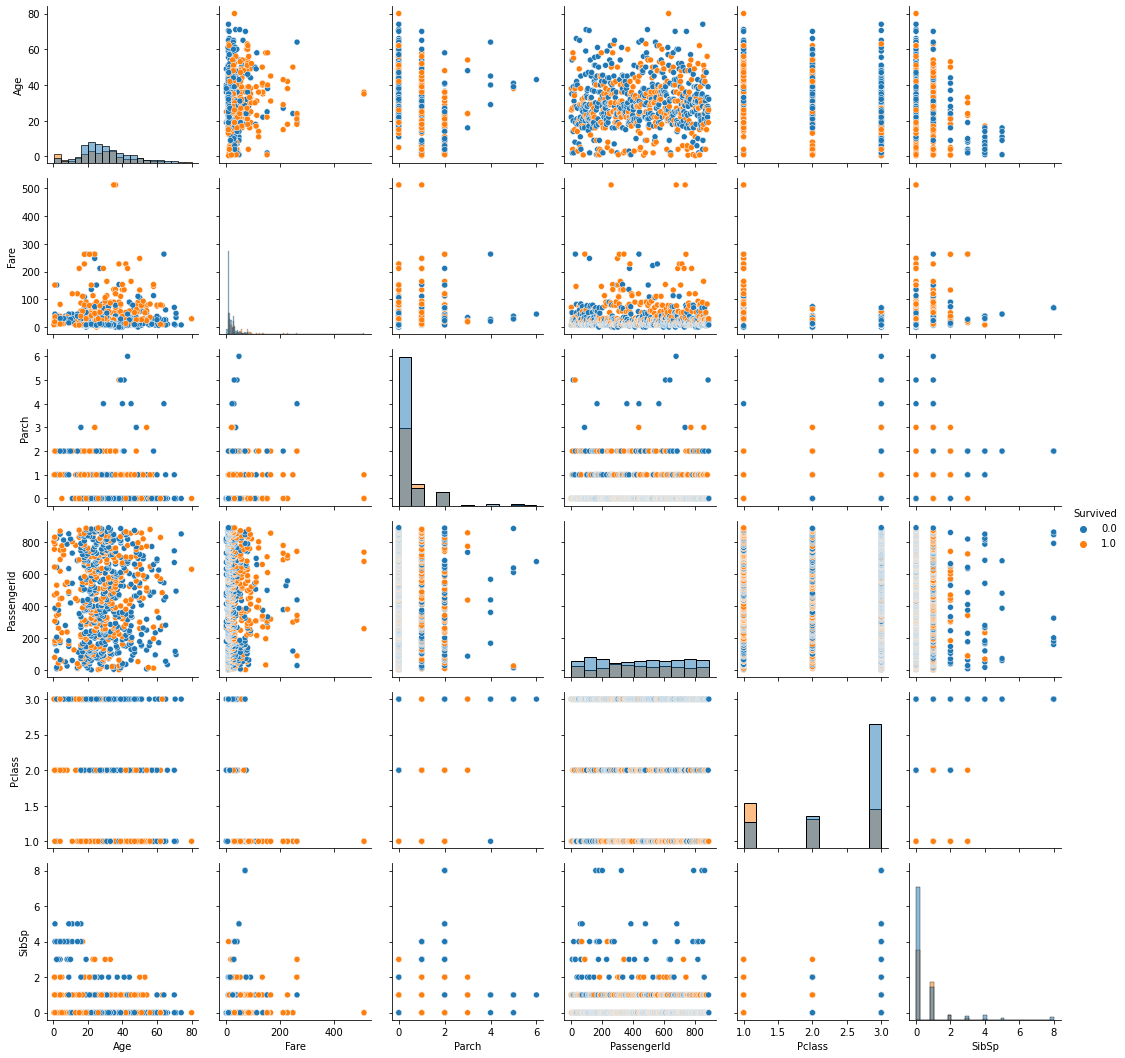

In [10]:
# Visualize pair-wise distribution of numerical features using a pair plot
pairPlot(df_data)
pairPlot(df_data, 'Survived')
# sns.pairplot(data=df_data, kind = 'reg')
# sns.pairplot(data=df_data, kind = 'hist', hue='Survived', palette={0:'blue',1:'green'})

<AxesSubplot:>

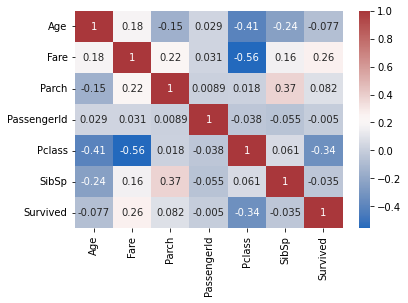

In [11]:
# Heat map to visualize correlation between variables
sns.heatmap(df_data.corr(), annot=True, cmap='vlag')

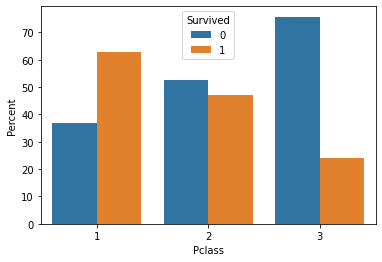

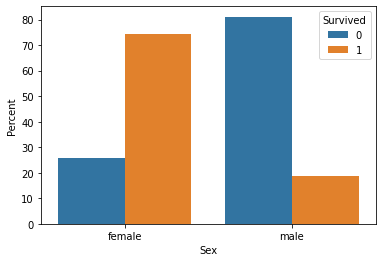

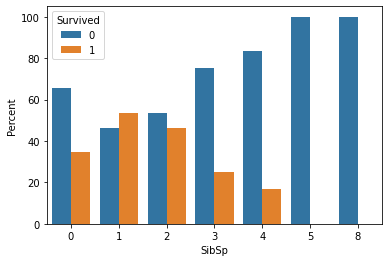

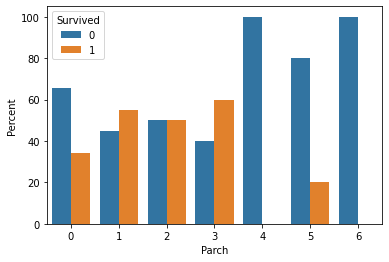

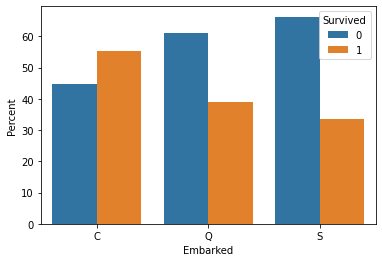

In [12]:
# Tally groups to see which features may be important for survival
# Especially categorical variables not visualized by pair plots above

# df_train.groupby(['Survived', 'Sex']).size()
def categoricalPlots(data, y=None):
    for col in data:
        if col == y:
            continue
        elif (len(data[col].unique())) < 10:
            x=col
            (data
            .groupby(x)[y]
            .value_counts(normalize=True)
            .mul(100)
            .rename('Percent')
            .reset_index()
            .pipe((sns.barplot, 'data'), x=x, y='Percent', hue=y))
            plt.show()
categoricalPlots(df_train, y='Survived')
# sns.countplot(x='Survived', hue='Sex', data = df_train)

**EDA KEY INSIGHTS**
1. There is class imbalance in the trainng set (more people died than survived)
2. There are no duplicate values
3. There are missing values for the following features: "Age", "Cabin", "Embarked", and "Fare". 
4. "Ticket" and "Cabin" are complex string variables that may be important indicator in predicting survival. 
5. Among numerical features, "Fare" is correlated with survival
6. All categorical features seem to be associated with survival, especially "Sex" and "PClass".  

<div style='color: white; display: fill; 
    border-radius: 8px; background-color: black;
    font-size: 150%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: white;'> 
        <b>2 &nbsp; Data processing</b>
    </p>
</div> 

### <b> 2.1 <span style='color:orange'> | </span> Imputation of missing values </b>

In [13]:
df_data['Title'] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(df_data['Title'], df_data['Sex']).transpose()

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [14]:
df_data['Surname'] = df_data.Name.str.extract('^([A-Za-z]+),', expand=False)
df_data[df_data.Surname.duplicated() & df_data.Surname.notna()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Surname
24,8.0,NaN,S,21.0750,"Palsson, Miss. Torborg Danira",1,25,3,female,3,0.0,349909,Miss,Palsson
68,17.0,NaN,S,7.9250,"Andersson, Miss. Erna Alexandra",2,69,3,female,4,1.0,3101281,Miss,Andersson
71,16.0,NaN,S,46.9000,"Goodwin, Miss. Lillian Amy",2,72,3,female,5,0.0,CA 2144,Miss,Goodwin
88,23.0,C23 C25 C27,S,263.0000,"Fortune, Miss. Mabel Helen",2,89,1,female,3,1.0,19950,Miss,Fortune
109,NaN,NaN,Q,24.1500,"Moran, Miss. Bertha",0,110,3,female,1,1.0,371110,Miss,Moran
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,50.0,C80,C,211.5000,"Widener, Mr. George Dunton",1,1299,1,male,1,NaN,113503,Mr,Widener
1300,3.0,NaN,S,13.7750,"Peacock, Miss. Treasteall",1,1301,3,female,1,NaN,SOTON/O.Q. 3101315,Miss,Peacock
1302,37.0,C78,Q,90.0000,"Minahan, Mrs. William Edward (Lillian E Thorpe)",0,1303,1,female,1,NaN,19928,Mrs,Minahan
1307,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,Mr,Ware


In [15]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<div style='color: white; display: fill; 
    border-radius: 8px; background-color: black;
    font-size: 150%; letter-spacing:0.5px'> 
    <p style='padding: 8px; color: white;'> 
        <b>3 &nbsp; Data modeling</b>
    </p>
</div> 

In [16]:
# Percent of women that survived
women = df_train.loc[df_train.Sex == 'female']['Survived']
pct_women = sum(women)/len(women)
print('% of women who survived:', pct_women)

# Percent of men that survived
men = df_train.loc[df_train.Sex == 'male']['Survived']
pct_men = sum(men)/len(men)
print('% of men who survived:', pct_men)

% of women who survived: 0.7420382165605095
% of men who survived: 0.18890814558058924


In [17]:
from sklearn.ensemble import RandomForestClassifier

Y_train = df_train['Survived']

features = ['Pclass', 'Sex', 'SibSp', 'Parch']
X_train = pd.get_dummies(df_train[features])
X_test = pd.get_dummies(df_test[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=7)
model.fit(X_train,Y_train)

RandomForestClassifier(max_depth=5, random_state=7)

In [18]:
predictions = model.predict(X_train)
acc_train = (1 - sum(abs(predictions - Y_train.to_numpy())) / len(predictions))
print('Prediction accuracy on training set: ', acc_train)

Prediction accuracy on training set:  0.8148148148148149


In [19]:
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': df_test.PassengerId, 
                      'Survived': predictions})
# output.to_csv('submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
